<a href="https://colab.research.google.com/github/deepakrana123us/melanoma-detection/blob/main/Deepak_Rana_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import all the libararies

In [3]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, cv2
import PIL
from tensorflow import keras
from keras import layers, models
from keras.layers import Conv2D, MaxPooling2D # Import other layers you need
import warnings
warnings.filterwarnings("ignore")

In [4]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

## Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


In [5]:
# Defining the path for train and test images
## Paths of train and test dataset on Google drive

data_dir_train = pathlib.Path("/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Test")


In [6]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


**Load using keras.preprocessing**

Let's load these images off disk using the helpful image_dataset_from_directory utility.

**Create a dataset**
**Define some parameters for the loader**

In [7]:
## Write your train dataset here

batch_size = 32
img_height = 180
img_width = 180
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset='training',
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Write your validation dataset here

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset='validation',
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# Loading the testing data
# using seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
# resizing images to the size img_height*img_width, while writting the dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_test,
                                                             seed=123,
                                                             image_size=(img_height,img_width),
                                                             batch_size=batch_size,
                                                             color_mode='rgb')

Found 118 files belonging to 9 classes.


In [10]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.

class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


**Visualize the data**

Create a code to visualize one instance of all the nine classes present in the dataset


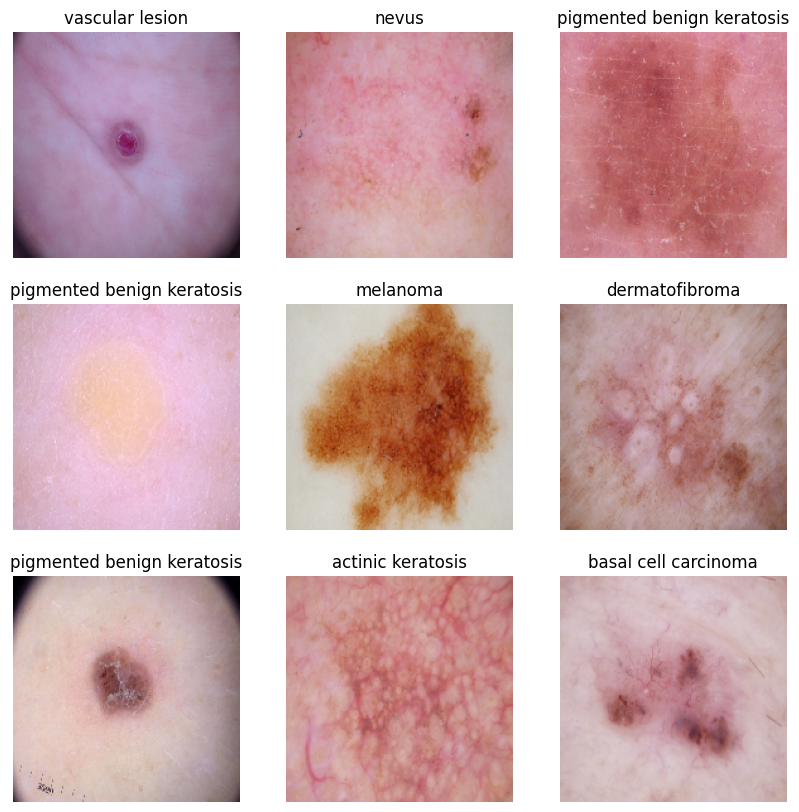

In [11]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

**Dataset.cache()** keeps the images in memory after they're loaded off disk during the first epoch.

**Dataset.prefetch()** overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [13]:
# Method to create plots of the loss and accuracy on the training and validation sets:
def plot_cnn_metrics(history,epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

**Create the CNN model**


In [14]:
# CNN Model
model=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(9,activation='softmax'))

In [15]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 259200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      66,355,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           2,313 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,433,417 (253.42 MB)

 Trainable params: 66,433,417 (253.42 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Training the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 872s 3s/step - accuracy: 0.1770 - loss: 4.9906 - val_accuracy: 0.3356 - val_loss: 1.8864
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.3620 - loss: 1.8156 - val_accuracy: 0.3870 - val_loss: 1.7266
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.4552 - loss: 1.5363 - val_accuracy: 0.5347 - val_loss: 1.4201
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.5557 - loss: 1.2725 - val_accuracy: 0.5078 - val_loss: 1.5283
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.5784 - loss: 1.1504 - val_accuracy: 0.4855 - val_loss: 1.6424
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.6373 - loss: 1.0219 - val_accuracy: 0.5414 - val_loss: 1.4697
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.6537 - loss: 0.9761 - val_accuracy: 0.4407 - val_loss: 1.8276
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.6927 - loss: 0.8806 - val_accuracy: 0.5257 - v



**Choosing an appropriate data augmentation strategy to resolve underfitting/overfittin**g

In [17]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

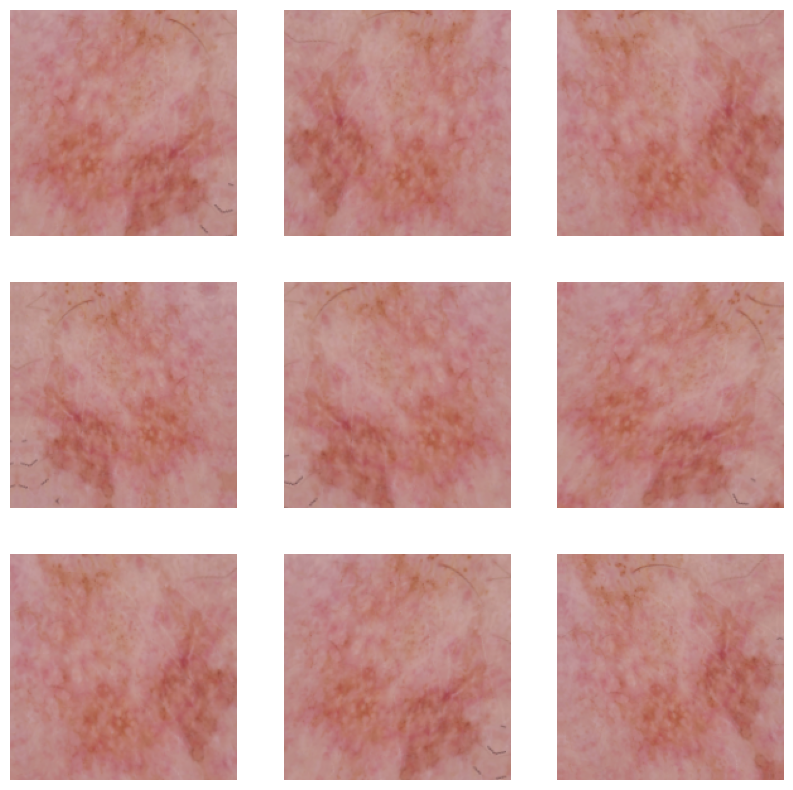

In [18]:
# visualizing how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

**Model Building & training on the augmented data :**
Creating a CNN model, which can accurately detect 9 classes present in the dataset. While building the model, rescaling images to normalize pixel values between (0,1).
Choosing an appropriate optimiser and loss function for model training
Training the model for ~20 epochs
Plotting Graph for findings after the model fit to check if there is any evidence of model overfit or underfit.

In [19]:
# CNN Model
model=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))

# adding the augmentation layer before the convolution layer
model.add(data_augmentation)

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(9,activation='softmax'))

In [20]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 180, 180, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 90, 90, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 259200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │      66,355,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │           2,313 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,433,417 (253.42 MB)

 Trainable params: 66,433,417 (253.42 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Training the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - accuracy: 0.2026 - loss: 5.0993 - val_accuracy: 0.2640 - val_loss: 2.1753
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.2829 - loss: 1.9714 - val_accuracy: 0.4541 - val_loss: 1.6399
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - accuracy: 0.4352 - loss: 1.6074 - val_accuracy: 0.3982 - val_loss: 1.7100
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.3839 - loss: 1.6715 - val_accuracy: 0.4586 - val_loss: 1.5626
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - accuracy: 0.4318 - loss: 1.6052 - val_accuracy: 0.4385 - val_loss: 1.5579
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.4304 - loss: 1.5729 - val_accuracy: 0.4430 - val_loss: 1.5431
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - accuracy: 0.4746 - loss: 1.4491 - val_accuracy: 0.5190 - val_loss: 1.4221
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.4981 - loss: 1.4124 - val_accuracy: 0.4899

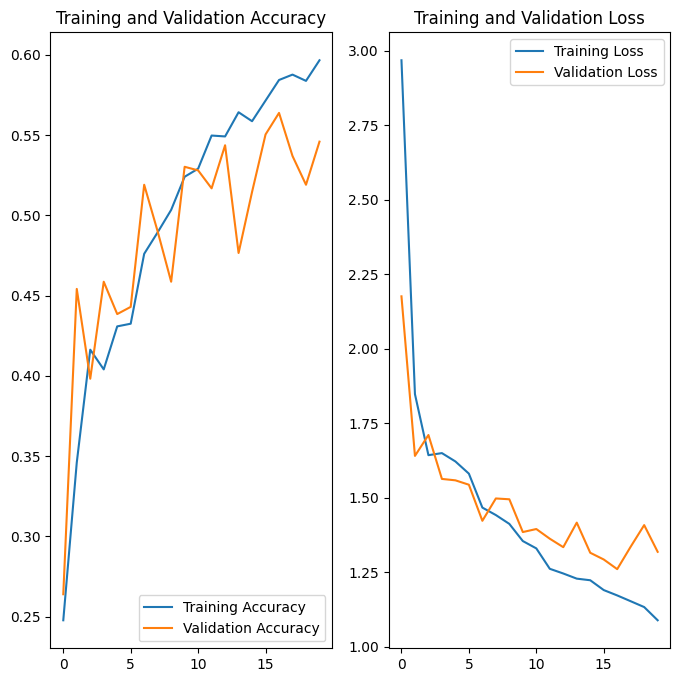

In [22]:
# Visualizing training results
plot_cnn_metrics(history,epochs)

**Findings :**
As the training accuracy increases linearly over time, where as the validation accuracy increases and stall at 55% accuracy in training process.
As the training loss decreases with epochs the validation loss decreases and stalls.
The plots show that gap between training accuracy and validation accuracy have decreased from previous model, and it has achieved around 55% accuracy on the validation set.
The difference in accuracy between training and validation accuracy is still slightly noticeable which is a sign of overfitting.

**Model Building & training on the augmented data with dropout :**
Creating a CNN model, which can accurately detect 9 classes present in the dataset. While building the model, rescaling images to normalize pixel values between (0,1).
Choosing an appropriate optimiser and loss function for model training


In [23]:
# CNN Model
model=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))
model.add(data_augmentation)

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())
#adding a 20% dropout after the convolution layers
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(9,activation='softmax'))

In [24]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 180, 180, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 90, 90, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 259200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │      66,355,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 9)                   │           2,313 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,433,417 (253.42 MB)

 Trainable params: 66,433,417 (253.42 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# Training the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 0.1783 - loss: 7.3098 - val_accuracy: 0.2841 - val_loss: 1.9638
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 0.2904 - loss: 1.9316 - val_accuracy: 0.3960 - val_loss: 1.7071
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 0.3885 - loss: 1.6714 - val_accuracy: 0.4743 - val_loss: 1.5810
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.4237 - loss: 1.5880 - val_accuracy: 0.4004 - val_loss: 1.7574
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.3953 - loss: 1.7005 - val_accuracy: 0.4877 - val_loss: 1.5865
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.4443 - loss: 1.5552 - val_accuracy: 0.5011 - val_loss: 1.5431
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 0.5049 - loss: 1.4106 - val_accuracy: 0.4922 - val_loss: 1.5402
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 0.4973 - loss: 1.4393 - val_accuracy: 

**Findings :**
As the training accuracy increases linearly over time, where as the validation accuracy increases and stall at 55% accuracy in training process.
As the training loss decreases with epochs the validation loss decreases
The plots show that gap between training accuracy and validation accuracy have decreased from previous model, and it has achieved around 55% accuracy on the validation set.
The difference in accuracy between training and validation accuracy is very less

We can clearly see that the overfitting of the model has redused significantly when compared the earlier models
Class distribution:
Examining the current class distribution in the training dataset

Datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others.

Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.



In [26]:
for i in range(len(class_names)):
  print(class_names[i],' - ',len(list(data_dir_train.glob(class_names[i]+'/*.jpg'))))


actinic keratosis  -  114
basal cell carcinoma  -  376
dermatofibroma  -  95
melanoma  -  438
nevus  -  357
pigmented benign keratosis  -  462
seborrheic keratosis  -  77
squamous cell carcinoma  -  181
vascular lesion  -  139


In [28]:
!pip install Augmentor


**Handling class imbalances:**
Rectifing class imbalances present in the training dataset with Augmentor library.

In [29]:
#path_to_training_dataset="/kaggle/input/melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
path_to_training_dataset=("/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")

import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i,output_directory="/kaggle/working/melanoma/"+i+"/")
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

OSError: The source directory you specified does not exist.

**Handling class imbalances:**
Rectifing class imbalances present in the training dataset with Augmentor library.